##### Iain's comments
In some of the cases it would be good to use more informative variable names e.g. _res, _class, etc. I would change res to pred_score, pred_prob, or pred_logists or something like that.
The function roc_auc_score_multiclass() is missing index in the argument.
I’m pretty sure pred_class should be named pred_proba/pred_score etc, not pred_class (pred_class sounds like it is the predicted class, but this is actually a continuous prediction).
Double check if there is a problem with precision_score.recall_score/f1_score and the pos_label argument e.g. the positive label should be 1.
In roc_auc_score_multiclass(), I would make the elements of eval_dict a dict, not a list where you have to remember the order of the input (see attached script)
I’ve attached a script for  computing various multiclass classification metrics. It’s not finished, but it’s a bit more streamlined and will give us more information. For classification – especially mutlitclass problems – we want to compute a ton of metrics to help understand what’s going on

In [1]:
# importing the libraries
import os
import sys
import pandas as pd
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import  glob
import time
import albumentations
import math
import shutil
from collections import Counter
from scipy.special import softmax
from sklearn.preprocessing import OneHotEncoder# creating instance of one-hot-encoder
from sklearn.model_selection import train_test_split

from models.ResNext50 import Myresnext50
from train.train_classification import trainer_classification
from utils.utils import configure_optimizers
from Datasets.DataLoader import Img_DataLoader

### PyTorch Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils import data
from torchvision import transforms
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask


In [2]:
cell_types_df = pd.read_pickle("cell_types_df.pkl")
cell_types_df.head()

Filepath Cell_Types  \
0   D:\Mathijs\Open Universiteit\Thesis\Implementa...      Other   
1   D:\Mathijs\Open Universiteit\Thesis\Implementa...    Myeloid   
35  D:\Mathijs\Open Universiteit\Thesis\Implementa...   Lymphoid   

   Final diagnosis Classnames  Cell_Types_Cat    0    1    2  
0              AML         LY               2  0.0  0.0  1.0  
1              AML         BL               1  0.0  1.0  0.0  
35           B-ALL         BL               0  1.0  0.0  0.0

In [3]:
# Load the data, split it into training and validation dataframes
df = pd.read_pickle('imagepaths.pkl')

train_df, val_df = train_test_split(df, test_size=0.20, random_state=42, stratify=df['Label'])
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state=42, stratify=val_df['Label'])
print(f"Training set shape: {train_df.shape}          Training set label count: {str(Counter(train_df['Label'].to_list()))[7:][1:][:-1]} \n")
print(f"Validation set shape: {val_df.shape}         Validation set label count: {str(Counter(val_df['Label'].to_list()))[7:][1:][:-1]} \n")
print(f"Test set shape: {test_df.shape}         Validation set label count: {str(Counter(test_df['Label'].to_list()))[7:][1:][:-1]} \n")

Training set shape: (16630, 4)          Training set label count: {'Other': 9477, 'Myeloid': 6195, 'Lymphoid': 958} 

Validation set shape: (2079, 4)         Validation set label count: {'Other': 1185, 'Myeloid': 774, 'Lymphoid': 120} 

Test set shape: (2079, 4)         Validation set label count: {'Other': 1184, 'Myeloid': 775, 'Lymphoid': 120} 



In [5]:
# Load filepaths, random state ensures testset is the same as in Training.ipynb
X_train = train_df['Filepath'].to_list()
X_val = val_df['Filepath'].to_list()
X_test = test_df['Filepath'].to_list()

# Load labels
train_labels = train_df['Label'].to_list()
validation_labels = val_df['Label'].to_list()
test_labels = test_df['Label'].to_list()

# Load df that represents the one hot encoding of each cell type (Myeloid, Lymphoid, other)
cell_types_df = pd.read_pickle("cell_types_df.pkl")

# Load model
resnext50_pretrained = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)
my_extended_model = Myresnext50(my_pretrained_model= resnext50_pretrained, num_classes = 3)

Using cache found in C:\Users\moone/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\moone\miniconda3\envs\thesis\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\moone\miniconda3\envs\thesis\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
## Simple normalization to improve the data generalibility

transform_pipeline = albumentations.Compose(
    [
        albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        
    ]
)

In [7]:
# Run this cell if you want to utilize checkpoints, otherwise run cell above
resnext50_pretrained = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d')
My_model = Myresnext50(my_pretrained_model= resnext50_pretrained, num_classes = 3)

checkpoint_PATH = 'checkpoints/checkpoint_best_202542316.ckpt'
checkpoint = torch.load(checkpoint_PATH)

# Function to remove 'module.' from the checkpoints, which must be removed because we do not use torch.nn.DataParallel
from collections import OrderedDict
def remove_data_parallel(old_state_dict):
    new_state_dict = OrderedDict()

    for k, v in old_state_dict.items():
        
        name = k[7:] # remove `module.`
        
        new_state_dict[name] = v
    
    return new_state_dict

checkpoint  = remove_data_parallel(checkpoint['model_state_dict'])

My_model.load_state_dict(checkpoint, strict=True)

Using cache found in C:\Users\moone/.cache\torch\hub\pytorch_vision_v0.10.0


<All keys matched successfully>

In [2]:
### ORIGINAL CODE BY DEEPHEME, REPLACED BY CELL BELOW BUT KEPT FOR REFERENCE
# X_train = glob.glob('../../2022_05_18_cells_50_NORMAL/Cross_Validation/iteration_3/train/*/*')
# X_val = glob.glob('../../2022_05_18_cells_50_NORMAL/Cross_Validation/iteration_3/val/*/*')

# labels = [x.split('/')[-2] for x in X_train]
# cell_types = set(labels)

# cell_types = list(cell_types)
# cell_types.sort()

# cell_types_df = pd.DataFrame(cell_types, columns=['Cell_Types'])# converting type of columns to 'category'
# cell_types_df['Cell_Types'] = cell_types_df['Cell_Types'].astype('category')# Assigning numerical values and storing in another column
# cell_types_df['Cell_Types_Cat'] = cell_types_df['Cell_Types'].cat.codes

# enc = OneHotEncoder(handle_unknown='ignore')# passing bridge-types-cat column (label encoded values of bridge_types)
# enc_df = pd.DataFrame(enc.fit_transform(cell_types_df[['Cell_Types_Cat']]).toarray())# merge with main df bridge_df on key values
# cell_types_df = cell_types_df.join(enc_df)

In [3]:
# Augmented code to store the data in two folders, uncomment if you want to store the files in a directory

# # Read data
# cell_types_df = pd.read_pickle("imagepaths.pkl")

# # First split into training and validation sets
# train_df, val_df = train_test_split(cell_types_df, test_size=0.15, random_state=42, stratify=cell_types_df['Label'])
# print(f"Training set shape: {train_df.shape}\nValidation set shape: {val_df.shape}")

# # Copy the images of the training and validation sets into a directory to use the same approach as Deepheme
# def copy_images(df_subset, target_dir):
#     for file_path in df_subset['Filepath']:
#         # Get just the filename (without directories)
#         file_name = os.path.basename(file_path)
#         # Define the destination path
#         dest_path = os.path.join(target_dir, file_name)
#         # Copy the file
#         shutil.copy(file_path, dest_path)

# # Copy images, uncomment below if you haven't copied them yet
# copy_images(train_df, 'Datasets/trainingset')
# copy_images(val_df, 'Datasets/validationset')

In [4]:
# Augmented code to read the data, only uncomment if you dont have cell_types_df.pkl

# cell_types_df = pd.read_pickle("imagepaths.pkl")

# cell_types_df = cell_types_df.rename(columns={"Filepath":"Filepath", "Label":"Cell_Types"}) # To align with the names used for Deepheme
# cell_types_df['Cell_Types'] = cell_types_df['Cell_Types'].astype('category') # Converting type of columns to 'category'
# cell_types_df['Cell_Types_Cat'] = cell_types_df['Cell_Types'].cat.codes # Assigning a numerical value to each category and storing in another column

# # Create one hot encoding for each category
# enc = OneHotEncoder(handle_unknown='ignore') # passing bridge-types-cat column (label encoded values of bridge_types)
# enc_df = pd.DataFrame(enc.fit_transform(cell_types_df[['Cell_Types_Cat']]).toarray()) # merge with main df bridge_df on key values
# cell_types_df = cell_types_df.join(enc_df)

# #drop duplicates to create a reference list of the encoding for later use
# cell_types_df = cell_types_df.drop_duplicates(subset = 'Cell_Types', keep='first')

# # Store in pickle file for reuse
# cell_types_df.to_pickle("cell_types_df.pkl")
# cell_types_df.head()

In [10]:
# #For testing purposes

# My_model = My_model.cuda().eval()
# Orig_img = Img_DataLoader(img_list=X_val, labels=validation_labels, split='viz',df=cell_types_df, transform=transform_pipeline)
# shuffle = False
# dataloader = DataLoader(Orig_img, batch_size=32, num_workers=2, shuffle=shuffle)

# for i, _batch in enumerate(dataloader):
#     if i > 1:
#         break
#     temp = _batch



In [11]:
# Testing purposes

# image = temp['image'].cuda()
# label = temp['label']
# ID    = [x for x in temp['ID']]

# pred_prob = My_model(images)
# pred_hidden_layer = My_model.pretrained(images)

# pred_prob2 = torch.flatten(pred_prob, start_dim=1).detach().cpu().numpy()
# label = torch.flatten(label, start_dim=1).cpu().numpy()
# pred_hidden_layer = torch.flatten(pred_hidden_layer, start_dim=1).detach().cpu().numpy()

# print(pred_prob.shape)
# pred_prob2.shape

In [12]:
# # gauranteed to work accuracy / code for testing purposes

#  #X_test_orig = cellnames[cellnames['dir'].isin(X_test)]
# My_model = My_model.cuda().eval()
# Orig_img = Img_DataLoader(img_list=X_test, labels=test_labels, split='viz',df=cell_types_df, transform=transform_pipeline)
# shuffle = False
# dataloader = DataLoader(Orig_img, batch_size=32, num_workers=2, shuffle=shuffle)

# predictions = []
# groundtruths=[]
# for p, _batch in enumerate(dataloader):
#  images = _batch['image'].cuda()
#  pred_prob = My_model(images)

#  for x in _batch['label']:
#      groundtruths.append(x[0][0].tolist())

#  for i in range(len(pred_prob)):
#      max = pred_prob[i][0]
#      index = 0
#      for j in range(3):
#          if pred_prob[i][j] > max:
#              max = pred_prob[i][j]
#              index = j

#      predictions.append(index)

In [13]:
# # Counting code for testing purposes
# for cat in range(3):
#     totalgrdtruth = 0
#     totalpreds = 0
#     count = 0
#     for i in range(len(predictions)):
#         if groundtruths[i] == cat:
#             totalgrdtruth+=1
            
#         if predictions[i] == cat:
#             totalpreds+=1
#             if groundtruths[i] == predictions[i]:
#                 count+=1

#     print(f"total groundtruths of class {cat}: {totalgrdtruth} \ntotal predictions of class {cat} : {totalpreds}\ntotal correct positive predictions: {count}\n")


total groundtruths of class 0: 120 
total predictions of class 0 : 0
total correct positive predictions: 0

total groundtruths of class 1: 775 
total predictions of class 1 : 2044
total correct positive predictions: 775

total groundtruths of class 2: 1184 
total predictions of class 2 : 35
total correct positive predictions: 35



In [15]:
#X_test_orig = cellnames[cellnames['dir'].isin(X_test)]
My_model = My_model.cuda().eval()
Orig_img = Img_DataLoader(img_list=X_test, labels=test_labels, split='viz',df=cell_types_df, transform=transform_pipeline)
shuffle = False
dataloader = DataLoader(Orig_img, batch_size=32, num_workers=2, shuffle=shuffle)


for i, _batch in enumerate(dataloader):
    
    if i == 0:

        images = _batch["image"].cuda()
        label = _batch["label"]
#        ID    = [x.split('/')[-2]+"_"+x.split('/')[-1] for x in _batch['ID']]
        ID    = [x for x in _batch['ID']]
        pred_prob = My_model(images)
        pred_hidden_layer = My_model.pretrained(images)

        pred_prob = torch.flatten(pred_prob, start_dim=1).detach().cpu().numpy()
        label = torch.flatten(label, start_dim=1).cpu().numpy()
        pred_hidden_layer = torch.flatten(pred_hidden_layer, start_dim=1).detach().cpu().numpy()
    else:
        images = _batch["image"].cuda()
        _label = _batch["label"]
#        _ID    = [x.split('/')[-2]+"_"+x.split('/')[-1] for x in _batch['ID']]
        _ID    = [x for x in _batch['ID']]
        _pred_prob = My_model(images)
        _pred_hidden_layer = My_model.pretrained(images)
        
        _pred_prob = torch.flatten(_pred_prob, start_dim=1).detach().cpu().numpy()
        _label = torch.flatten(_label, start_dim=1).cpu().numpy()  
        _pred_hidden_layer = torch.flatten(_pred_hidden_layer, start_dim=1).detach().cpu().numpy()
        
        ID = ID + _ID
        pred_prob = np.concatenate((pred_prob, _pred_prob))
        label = np.concatenate((label, _label))
        pred_hidden_layer = np.concatenate((pred_hidden_layer, _pred_hidden_layer))
pred_prob = softmax(pred_prob, axis=1)
print(pred_prob.shape)
print(label.shape)
print(pred_hidden_layer.shape)
print(len(ID))
#pred_class_binary = np.where(res,np.max(res, axis =1))

for i in range(pred_prob.shape[0]):
    if i == 0:
        predict_class = np.where(pred_prob[i] == np.max(pred_prob[i]),1,0).reshape(1,3)
    else:
        _predict_class = np.where(pred_prob[i] == np.max(pred_prob[i]),1,0).reshape(1,3)
        predict_class = np.concatenate((predict_class, _predict_class), axis =0)
print(predict_class.shape)

(2079, 3)
(2079, 1)
(2079, 1000)
2079
(2079, 3)


In [17]:
columns = ['Lymphoid', 'Myeloid', 'Other']

df_label = pd.DataFrame(data=test_labels, index=ID, columns=['label'])

enc = OneHotEncoder(handle_unknown='ignore') # passing bridge-types-cat column (label encoded values of bridge_types)
df_label = pd.DataFrame(enc.fit_transform(df_label[['label']]).toarray(), index=ID) # merge with main df bridge_df on key values
df_label = df_label.rename(columns={0: 'Lymphoid', 1:'Myeloid', 2:"Other"})

pred_prob = pd.DataFrame(data=pred_prob, index=ID, columns=columns)
pred_class = pd.DataFrame(data=predict_class, index=ID, columns=columns)

In [18]:
from sklearn.metrics import (roc_auc_score, accuracy_score, recall_score, precision_score, f1_score)
from scipy.special import softmax
def evaluation_metrics_multiclass(label, pred_prob, pred_class):
    #creating a set of all the unique classes using the actual class list
    classes = df_label.columns
    eval_dict = {}
    
    for per_class in classes:
        #creating a list of all the classes except the current class 
        groundtruth_per_class  = df_label[per_class].tolist()
        pred_prob_per_class    = pred_prob[per_class].tolist()
        pred_class_per_class = pred_class[per_class].tolist()
        #marking the current class as 1 and all other classes as 0

        roc_auc = roc_auc_score(groundtruth_per_class, pred_prob_per_class)
        f1 = f1_score(groundtruth_per_class, pred_class_per_class)
        acc = accuracy_score(groundtruth_per_class, pred_class_per_class)
        precision = precision_score(groundtruth_per_class, pred_class_per_class)
        recall = recall_score(groundtruth_per_class, pred_class_per_class)
        used_metrics = ['AUC','F1','Acc','Precision','Recall']
        eval_dict[per_class] = [roc_auc, f1, acc, precision, recall]

    return eval_dict


# assuming your already have a list of actual_class and predicted_class from the logistic regression classifier
multiclass = evaluation_metrics_multiclass(df_label, pred_prob, pred_class)
print(multiclass)

{'Lymphoid': [0.5528075548749363, 0.0, 0.9422799422799423, 0.0, 0.0], 'Myeloid': [0.7676276469424104, 0.5498403689251508, 0.38961038961038963, 0.37915851272015655, 1.0], 'Other': [0.7690519779556092, 0.05742411812961444, 0.44733044733044736, 1.0, 0.02956081081081081]}


C:\Users\moone\miniconda3\envs\thesis\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
df = pd.DataFrame.from_dict(multiclass)
df.index = ['AUC','F1','Acc','Precision','Recall']
df.T

AUC        F1      Acc  Precision    Recall
Lymphoid  0.552808  0.000000  0.94228   0.000000  0.000000
Myeloid   0.767628  0.549840  0.38961   0.379159  1.000000
Other     0.769052  0.057424  0.44733   1.000000  0.029561

In [20]:
from utils.utils import one_vs_rest_metrics, get_overall_multiclass_metrics

In [21]:
df_one_vs_rest = one_vs_rest_metrics(np.argmax(df_label.to_numpy(), axis=1),
                    np.argmax(pred_class.to_numpy(), axis=1), 
                    pred_prob.to_numpy())
df_one_vs_rest.index = cell_types_df['Cell_Types'].tolist()
df_one_vs_rest

auc        f1  n_true  n_pred
Other     0.552808  0.000000     120       0
Myeloid   0.767628  0.549840     775    2044
Lymphoid  0.769052  0.057424    1184      35

In [22]:
df_overall_multiclass_metrics = get_overall_multiclass_metrics(np.argmax(df_label.to_numpy(), axis=1),
                    np.argmax(pred_class.to_numpy(), axis=1), 
                    pred_prob.to_numpy())
df_overall_multiclass_metrics

{'accuracy': 0.38961038961038963,
 'balanced_accuracy': 0.3431869369369369,
 'auc_ovr_macro': 0.6964957265909852,
 'auc_ovr_weighted': 0.7560393818493515}

## Grad-CAM 

In [8]:
# Run this cell if you want to utilize checkpoints, otherwise run cell above
resnext50_pretrained = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d')
My_model = Myresnext50(my_pretrained_model= resnext50_pretrained, num_classes = 3)

checkpoint_PATH = 'checkpoints/checkpoint_best_202542316.ckpt'
checkpoint = torch.load(checkpoint_PATH)

# Function to remove 'module.' from the checkpoints, which must be removed because we do not use torch.nn.DataParallel
from collections import OrderedDict
def remove_data_parallel(old_state_dict):
    new_state_dict = OrderedDict()

    for k, v in old_state_dict.items():
        
        name = k[7:] # remove `module.`
            
        new_state_dict[name] = v
    
    return new_state_dict

checkpoint  = remove_data_parallel(checkpoint['model_state_dict'])

My_model.load_state_dict(checkpoint, strict=True)

Using cache found in C:\Users\moone/.cache\torch\hub\pytorch_vision_v0.10.0


<All keys matched successfully>

In [9]:
My_model.cuda().eval()
Orig_img = Img_DataLoader(img_list=X_test, labels=test_labels, split='viz',df=cell_types_df, transform=transform_pipeline)
shuffle = False
dataloader = DataLoader(Orig_img, batch_size=1, num_workers=2, shuffle=shuffle)

In [10]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

def gradcam(My_model, batch):
    target_layers = [My_model.pretrained.layer4[-1]]
    input_tensor = batch['image']
    
    x = batch['ID']
    x = cv2.imread(x[0])
    x = cv2.resize(x,(256,256))
    rgb_img = x.astype(np.float32) / 255.0
    
    # We have to specify the target we want to generate the CAM for.
    targets = [ClassifierOutputTarget(int(batch['label']))]
    
    # Construct the CAM object once, and then re-use it on many images.
    with GradCAM(model=My_model, target_layers=target_layers) as cam:
      # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
      grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    
      # In this example grayscale_cam has only one image in the batch:
      grayscale_cam = grayscale_cam[0, :]
    
      visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
      # You can also get the model outputs without having to redo inference
      model_outputs = cam.outputs
    return visualization

In [11]:
images = []
labels = []
for i, batch in enumerate(dataloader):
    if i > 20:
        break
    images.append(gradcam(My_model, batch))
    if (int(batch['label'][0])) == 0:
        labels.append('Lymphoid')
    elif (int(batch['label'][0])) == 1:
        labels.append('Myeloid')
    elif (int(batch['label'][0])) == 2:
        labels.append('Other')

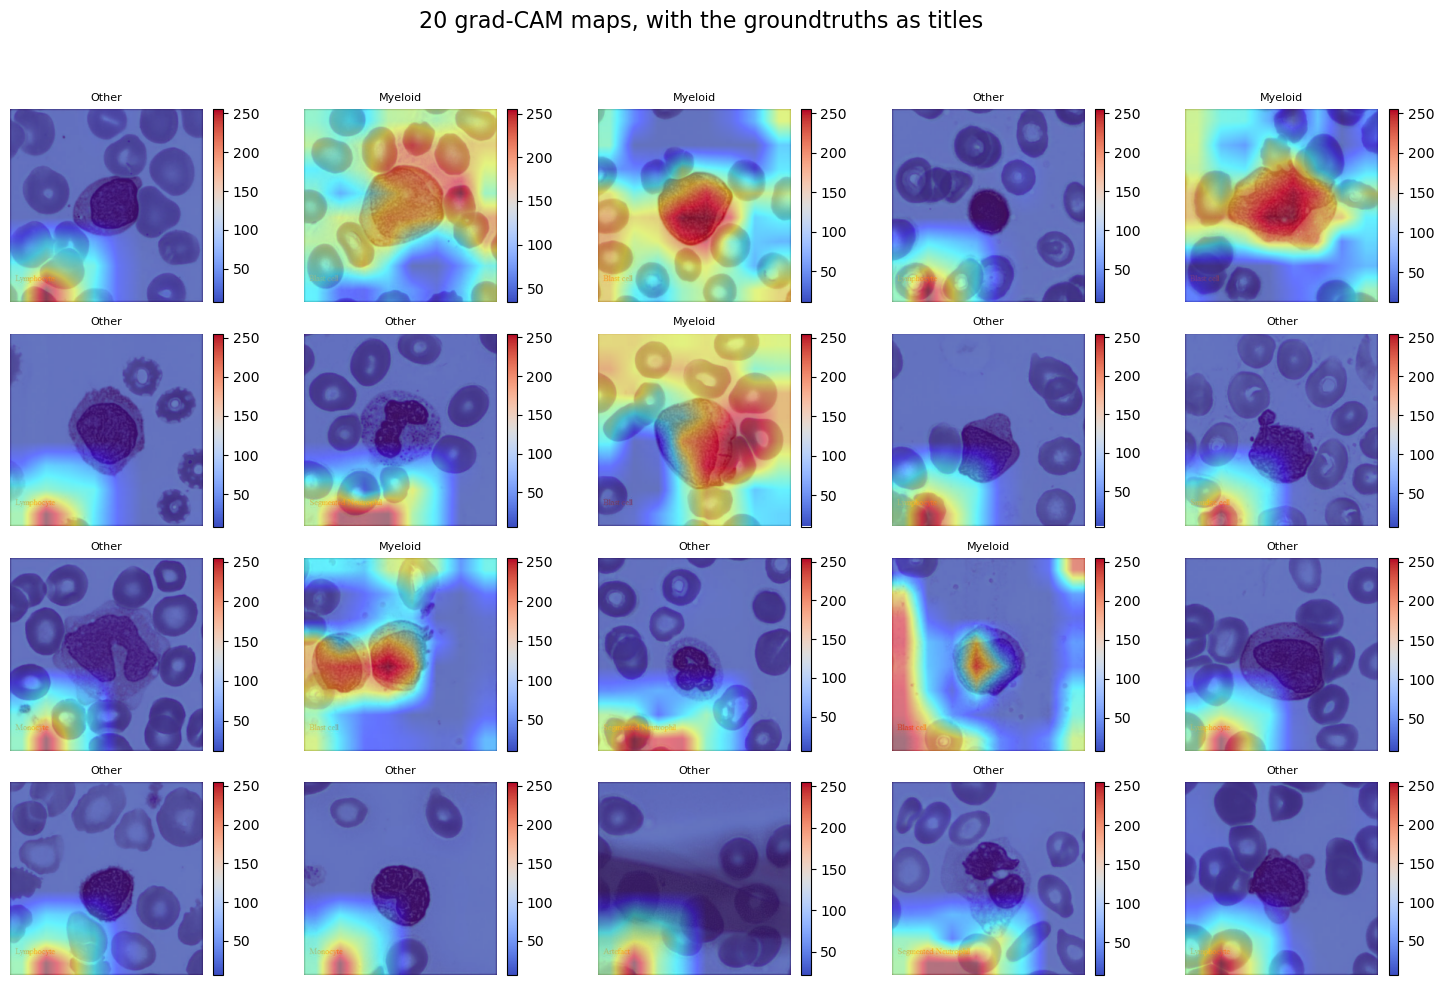

In [12]:
rows, cols = 4, 5  # 4x5 grid
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
fig.suptitle('20 grad-CAM maps, with the groundtruths as titles', fontsize=16)

for i, ax in enumerate(axes.flat):
    im = ax.imshow(images[i], cmap='coolwarm')
    ax.set_title(labels[i], fontsize=8)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)  # individual colorbars

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for title
plt.show()

In [13]:
filepaths = []
for i, _batch in enumerate(dataloader):
    filepaths.append(_batch['ID'][0])
    if i > 30:
        break

In [32]:
def segment_cell(filepath):

    # Load image
    img = cv2.imread(filepath)

        
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Define HSV range for purple
    lower_purple = np.array([120, 40, 40])   # Adjust as needed
    upper_purple = np.array([160, 255, 255])
    
    # Remove everything that isn't in the purple range
    mask = cv2.inRange(img_hsv, lower_purple, upper_purple)


    # Make bottom right corner, where text is, always black
    mask_height, mask_width = mask.shape
    x_start, y_start = 0, int(mask_height * 0.85)     # Bottom 10% of image
    x_end, y_end = int(mask_width * 0.35), mask_height  # Left 35% width

    mask[y_start:y_end, x_start:x_end] = 0  
    
    # Apply mask to RGB image
    result = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)
    
    # Set background to black explicitly (make sure to mask everything else)
    black_background = np.zeros_like(img_rgb)
    img_segmented = np.where(mask[:, :, None] > 0, result, black_background)
    
    return img_rgb, img_segmented

In [33]:
orig_images = []
seg_images = []

for filepath in filepaths:
    img_rgb, img_segmented = segment_cell(filepath)
    orig_images.append(img_rgb)
    seg_images.append(img_segmented)


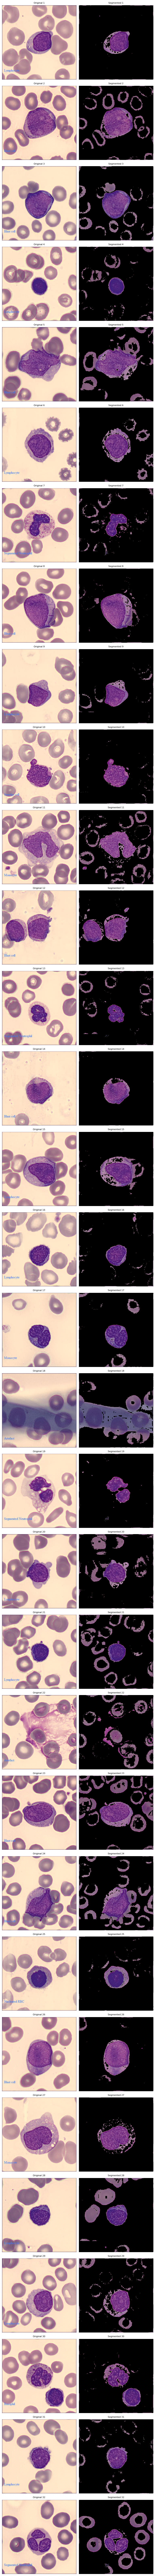

In [34]:
# Assume orig_images and seg_images are lists of shape (H, W, 3) arrays
assert len(orig_images) == len(seg_images) == 32

# Create figure
fig, axes = plt.subplots(nrows=32, ncols=2, figsize=(8, 128))  # Tall figure!

for i in range(32):
    # Original
    axes[i, 0].imshow(orig_images[i])
    axes[i, 0].set_title(f'Original {i+1}', fontsize=8)
    axes[i, 0].axis('off')
    
    # Segmented
    axes[i, 1].imshow(seg_images[i])
    axes[i, 1].set_title(f'Segmented {i+1}', fontsize=8)
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [17]:
import cv2
import numpy as np

def nothing(x):
    pass

# Load image and convert to HSV
img = cv2.imread(filepaths[0])
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# Create window
cv2.namedWindow('Trackbars')

# Create HSV trackbars
cv2.createTrackbar('H Min', 'Trackbars', 120, 179, nothing)
cv2.createTrackbar('H Max', 'Trackbars', 160, 179, nothing)
cv2.createTrackbar('S Min', 'Trackbars', 40, 255, nothing)
cv2.createTrackbar('S Max', 'Trackbars', 255, 255, nothing)
cv2.createTrackbar('V Min', 'Trackbars', 40, 255, nothing)
cv2.createTrackbar('V Max', 'Trackbars', 255, 255, nothing)

while True:
    # Get values from trackbars
    h_min = cv2.getTrackbarPos('H Min', 'Trackbars')
    h_max = cv2.getTrackbarPos('H Max', 'Trackbars')
    s_min = cv2.getTrackbarPos('S Min', 'Trackbars')
    s_max = cv2.getTrackbarPos('S Max', 'Trackbars')
    v_min = cv2.getTrackbarPos('V Min', 'Trackbars')
    v_max = cv2.getTrackbarPos('V Max', 'Trackbars')

    # Create mask
    lower = np.array([h_min, s_min, v_min])
    upper = np.array([h_max, s_max, v_max])
    mask = cv2.inRange(hsv, lower, upper)
    result = cv2.bitwise_and(img, img, mask=mask)

    # Show original and result
    cv2.imshow('Masked Image', result)
    cv2.imshow('Mask', mask)

    if cv2.waitKey(1) & 0xFF == 27:  # Press 'Esc' to exit
        break

cv2.destroyAllWindows()


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window_w32.cpp:2564: error: (-27:Null pointer) NULL window: 'Trackbars' in function 'cvGetTrackbarPos'
